# Assignment 3 Exercise 2

## Description
Use `negative selection` to detect the anomalous sequences in the system calls dataset: `snd-cert`

Perform an AUC analysis to evaluate the quality of your classification. Choose the parameters n and r for the negative selection algorithm yourself. You can use the parameters from the language example as a starting point.

In [1]:
import math
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
# global variables
CERT = "negative-selection/syscalls/snd-cert/"
UNM = "negative-selection/syscalls/snd-unm/"
OUT = "syscalls-classification/"
OVERLAP = False
CHUNK_LENGTH = 7
R_LENGTH = 7
TEST_N = 3

Max value of `CHUNK_LENGTH` = 7 because that is the smallest sequence length in the given training dataset. 

Range of `R_LENGTH` = (0, `CHUNK_LENGTH`)

### Step 1: Dataset Pre-processing

Define helper functions for pre-processing datasets

In [3]:
def read_data(path):
    '''function to read files'''
    with open(path, "r") as data:
        lines = data.read().splitlines()
    return lines

def fixed_length_chunks(string, length, overlap=False):
    '''function to create a fixed length chunks of a dataset'''
    step = 1 if overlap else length
    max_step = max(len(string) - length + 1, 1) if overlap else len(string)
    chunks = list( (string[i:length+i] for i in range(0, max_step, step)) )
    if not overlap:
        last_chunk_length_diff = length - len(chunks[-1])
        # force last chunk to be fixed length by adding a part from the penultimate chunk
        if len(chunks) > 1 and last_chunk_length_diff != 0:
            chunks[-1] = (chunks[-2] + chunks[-1])[-length:]
    return chunks

Functions for training data

In [4]:
def remove_duplicates(chunks):
    """Removes duplicate chunks (use only for training data)."""
    duplicates = set()
    output = []
    for chunk in chunks:
        if chunk not in duplicates:
            duplicates.add(chunk)
            output.append(chunk)
    return output

def process_train_sequences(sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [fixed_length_chunks(seq, chunk_length, overlap) for seq in sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return remove_duplicates(chunks)    

def write_train_data(chunks, out_dir):
    '''function to write chunks in a file'''
    with open(out_dir, "w") as train:
        train.write('\n'.join(chunks))

Functions for test data

In [5]:
def read_test_and_labels(path_no_ext):
    '''function to fetch test dataset files'''
    test = read_data(path_no_ext + ".test")
    labels = read_data(path_no_ext + ".labels")
    return test, labels

def process_test_sequences(labeled_sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [list(map(lambda x: (x, label), fixed_length_chunks(seq, chunk_length, overlap)))
                         for seq, label in labeled_sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return chunks

def write_test_data(labeled_chunks, out_dir_no_ext):
    '''function to write chunks in a file'''
    chunks = [chunk for chunk, _ in labeled_chunks]
    lbls = [label for _, label in labeled_chunks]
    with open(out_dir_no_ext + ".test", "w") as test, open(out_dir_no_ext + ".labels", "w") as labels:
        test.write('\n'.join(chunks))
        labels.write('\n'.join(lbls))

Functions for preprocessing datasets

In [6]:
def preprocess_train_data(chunk_length, overlap):
    # snd-cert
    train_cert = read_data(CERT + "snd-cert.train")
    chunks_cert = process_train_sequences(train_cert, chunk_length, overlap)
    write_train_data(chunks_cert, OUT + "snd-cert/snd-cert.{}.train".format(chunk_length))
    
def preprocess_test_data(chunk_length, overlap):
    for i in range(1, 4):
        # snd-cert
        test_cert, labels_cert = read_test_and_labels(CERT + f"snd-cert.{i}")
        labeled_chunks_cert = process_test_sequences(zip(test_cert, labels_cert), chunk_length, overlap)
        write_test_data(labeled_chunks_cert, OUT + f"snd-cert/snd-cert.{chunk_length}.{i}")

Pre-process training and test datasets

In [7]:
# for chk_len in tqdm(range(1, CHUNK_LENGTH + 1)):
#     preprocess_train_data(chk_len, overlap=OVERLAP)

In [8]:
# for chk_len in tqdm(range(1, CHUNK_LENGTH + 1)):
#     preprocess_test_data(chk_len, overlap=OVERLAP)

### Step 2: Classification Task

#### TO-DO: use all test files (cert) + experiment with different $n$ (chunk size) and $r$

*Note: max chunk size must be 7 (i.e., only test up $n$ up to 7 and not higher) because the smallest sequence in the data is of length 7 (any higher would mean the chunks cannot be fixed length).*

Functions to perform AUC analysis

In [9]:
def get_AUC(anomaly_labels, anomaly_scores):
    """Compute AUC from labels and predictions (scores)."""
    fpr, tpr, thresholds = metrics.roc_curve(anomaly_labels, anomaly_scores, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_ROC(fpr, tpr, title="", filename=None):
    """Plot ROC with its AUC."""
    auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], '--')
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    if filename:
        plt.savefig(f'figures/{filename}.png')
    plt.show()

basic example with snd-cert1.test 

to test every file make a loop that loops through every test file possibly make a loop to test different r as well

In [10]:
# static variables
cert_data_path = OUT + "snd-cert/"
jar = f"-jar negative-selection/negsel2.jar"
alpha = f"-alphabet file://{CERT}snd-cert.alpha"

In [11]:
# create tuples of CHUNK_LENGTH and R_LENGTH for experiments
chunk_r_tuples = [(i,j) for i in range(1, CHUNK_LENGTH+1) for j in range(1, i+1)]
# dictionary for storing AUC values
auc_dict = dict()

Execute Negative Selection algorithm on `snd-cert` dataset and perform AUC Analysis

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.1.1.test
AUC: 0.5039765592298032


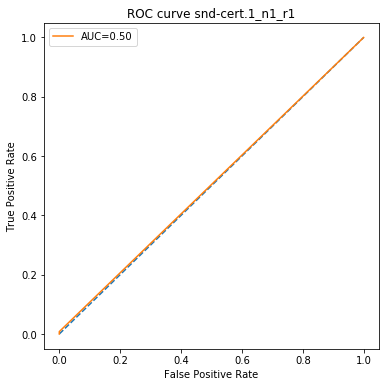

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.1.2.test
AUC: 0.5039542143600416


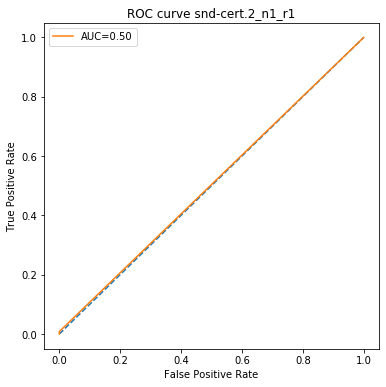

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.1.train -n 1 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.1.3.test
AUC: 0.5028863288871044


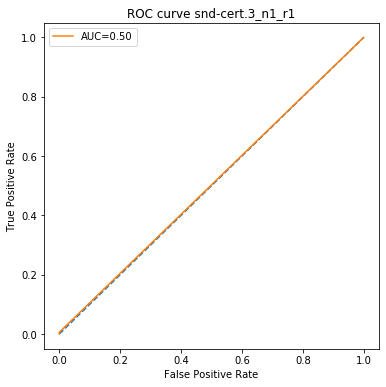

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.2.1.test
AUC: 0.505020920502092


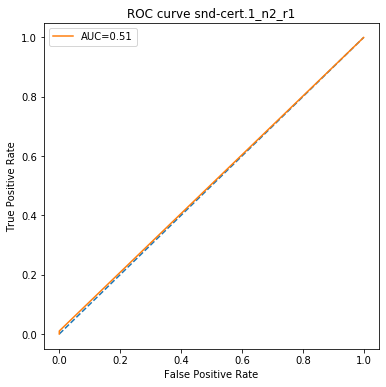

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.2.2.test
AUC: 0.5058214165096183


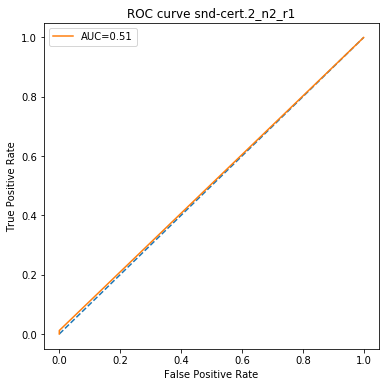

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.2.3.test
AUC: 0.5055581415324735


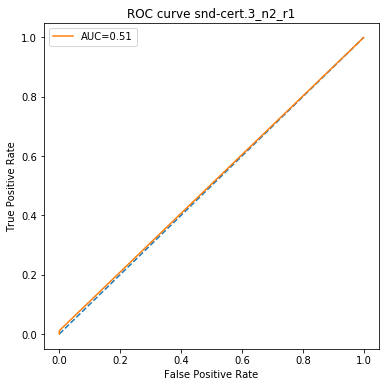

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.2.1.test
AUC: 0.5422594142259414


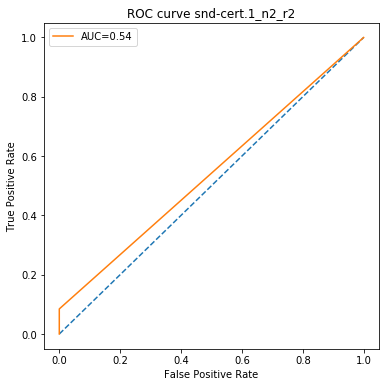

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.2.2.test
AUC: 0.5380564268653472


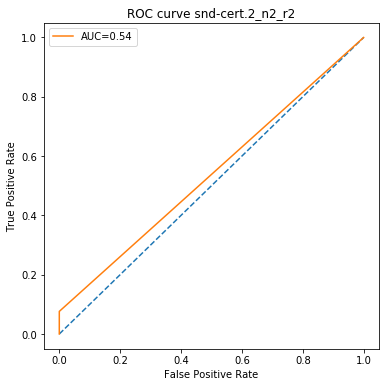

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.2.train -n 2 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.2.3.test
AUC: 0.5477969646521007


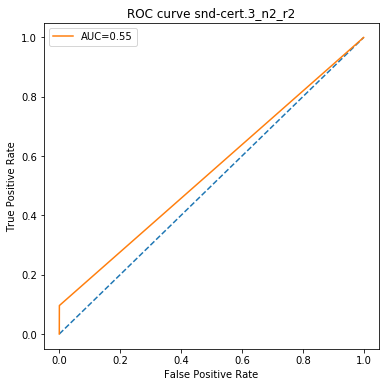

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.3.1.test
AUC: 0.5089285714285714


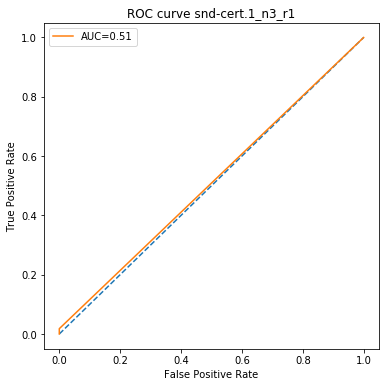

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.3.2.test
AUC: 0.5097779686237769


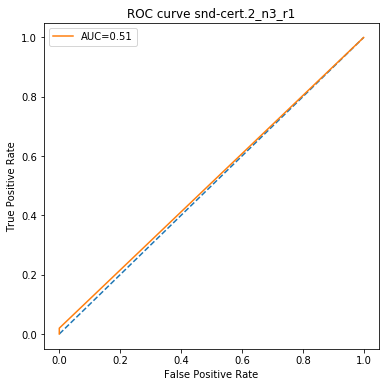

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.3.3.test
AUC: 0.5128194263731372


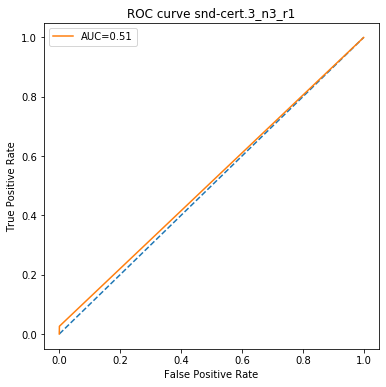

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.3.1.test
AUC: 0.582820197044335


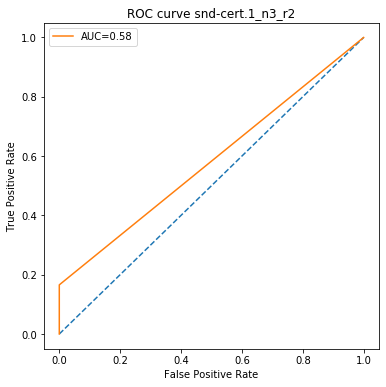

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.3.2.test
AUC: 0.5611497000764512


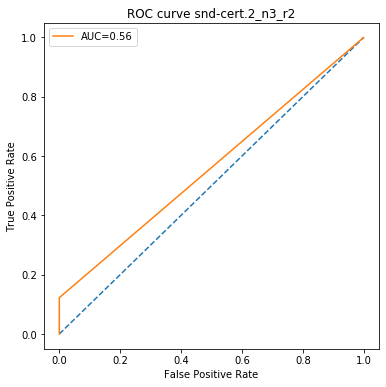

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.3.3.test
AUC: 0.5842853656773085


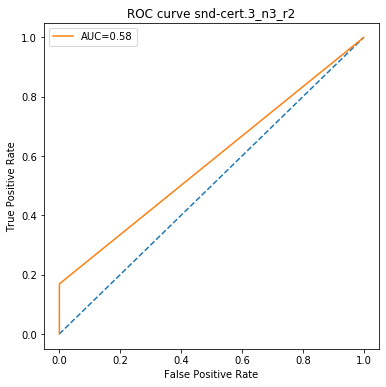

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.3.1.test
AUC: 0.5899014778325123


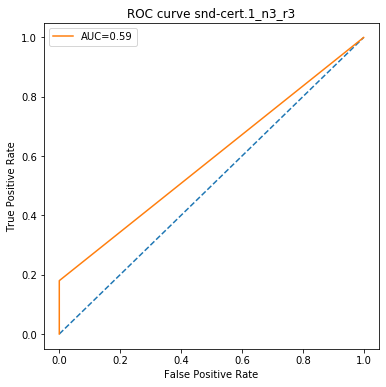

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.3.2.test
AUC: 0.5703061722906367


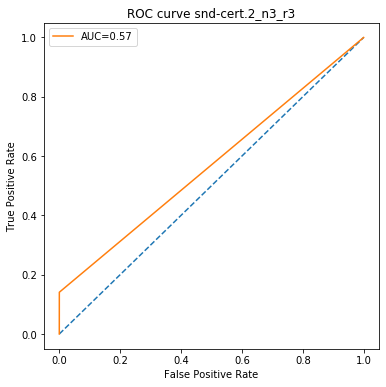

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.3.train -n 3 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.3.3.test
AUC: 0.5904712754014486


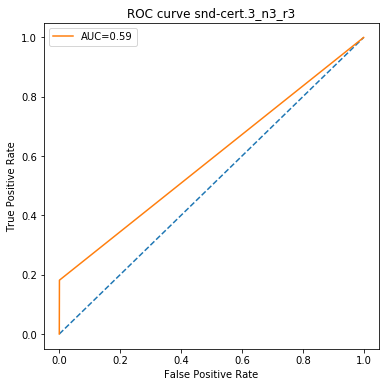

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.4.1.test
AUC: 0.5104427736006684


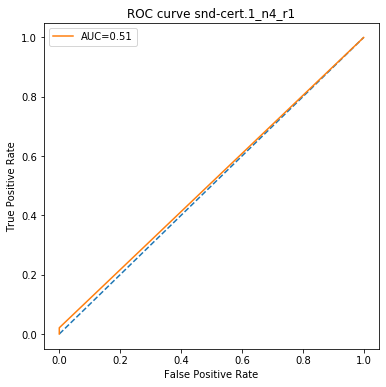

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.4.2.test
AUC: 0.5128614146116742


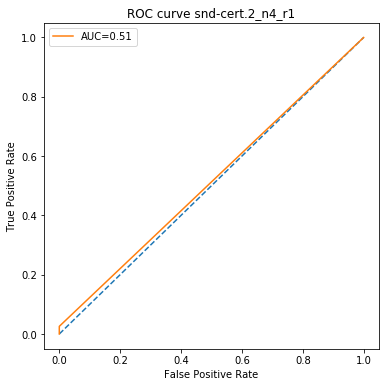

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.4.3.test
AUC: 0.5153193059593402


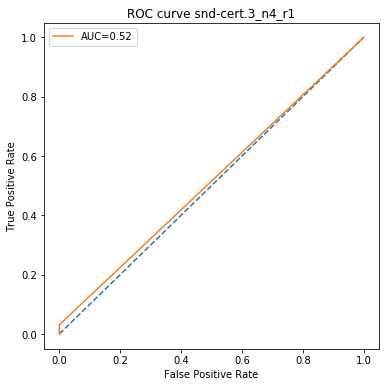

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.4.1.test
AUC: 0.5923985478496757


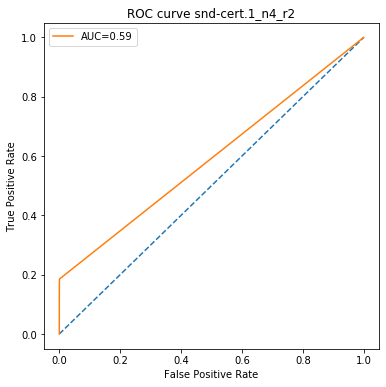

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.4.2.test
AUC: 0.5754990150250485


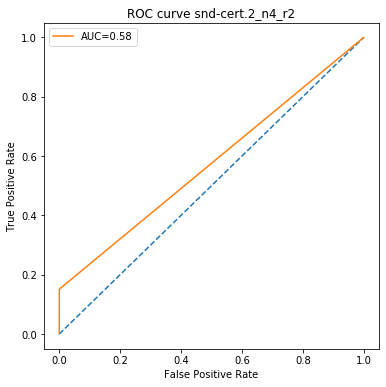

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.4.3.test
AUC: 0.606193590616827


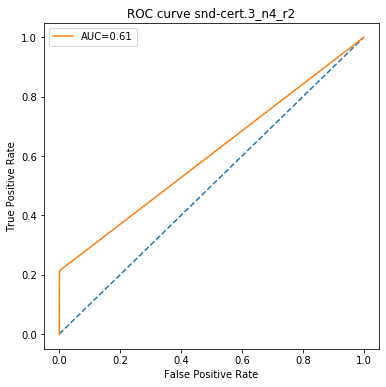

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.4.1.test
AUC: 0.6295004725455853


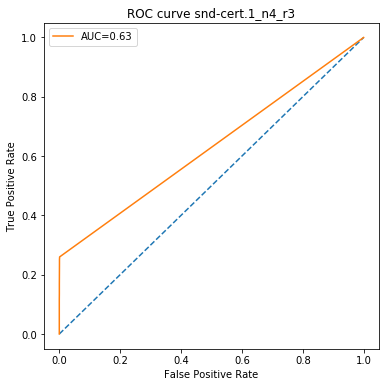

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.4.2.test
AUC: 0.6070493789576173


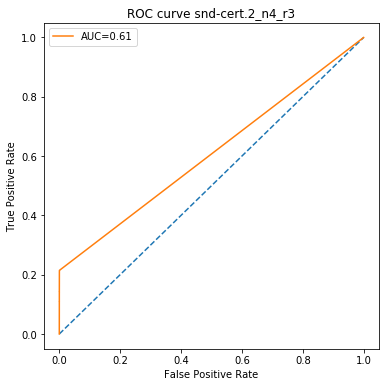

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.4.3.test
AUC: 0.641810674365049


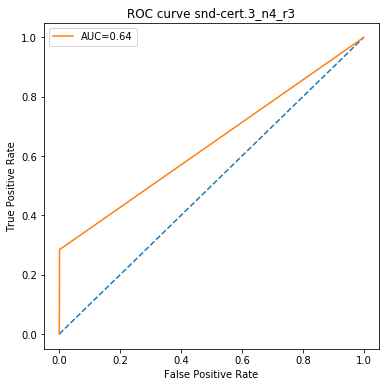

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.4.1.test
AUC: 0.631931743773849


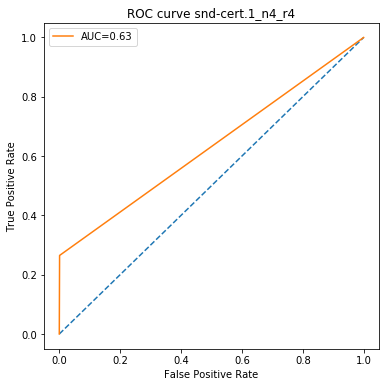

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.4.2.test
AUC: 0.6099455566435837


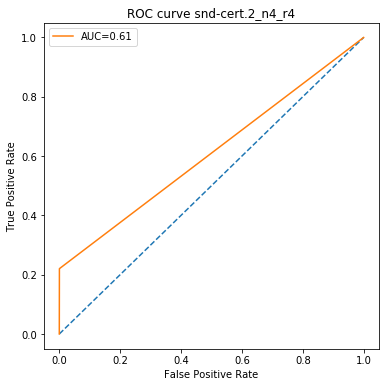

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.4.train -n 4 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.4.3.test
AUC: 0.6455894104000643


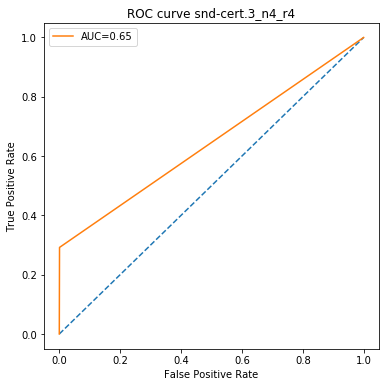

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.5.1.test
AUC: 0.5297805642633229


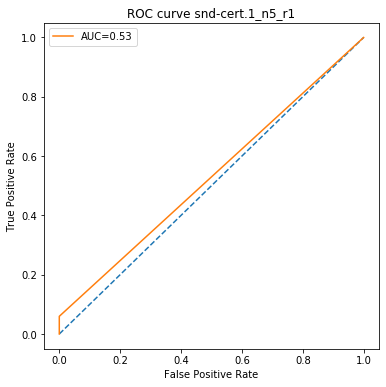

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.5.2.test
AUC: 0.5275062076065011


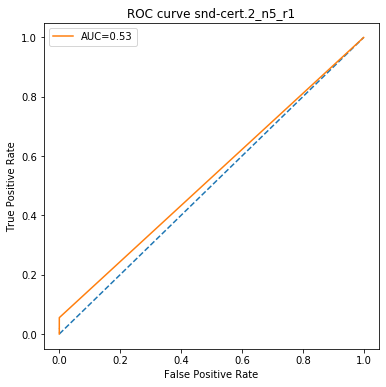

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.5.3.test
AUC: 0.5328721387423049


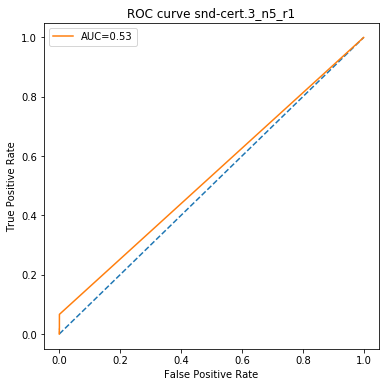

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.5.1.test
AUC: 0.61430512142751


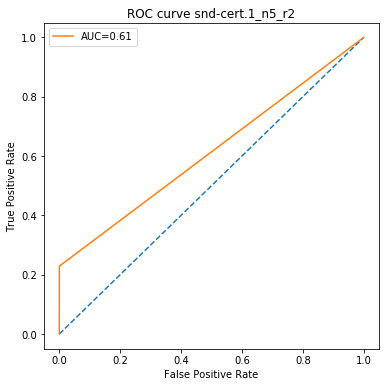

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.5.2.test
AUC: 0.5929226723013415


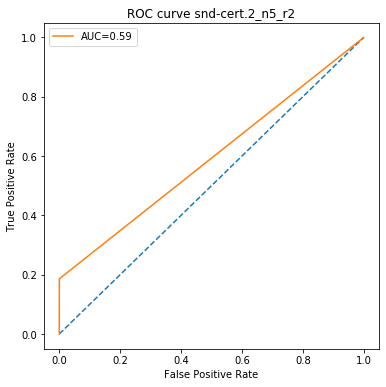

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.5.3.test
AUC: 0.6136456878463186


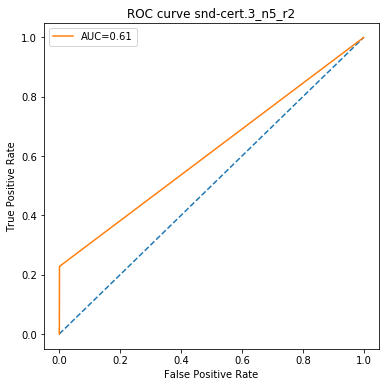

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.5.1.test
AUC: 0.6684681693977191


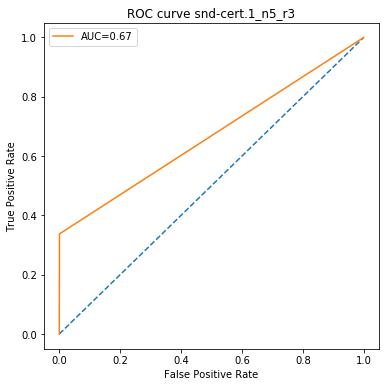

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.5.2.test
AUC: 0.6468946662195194


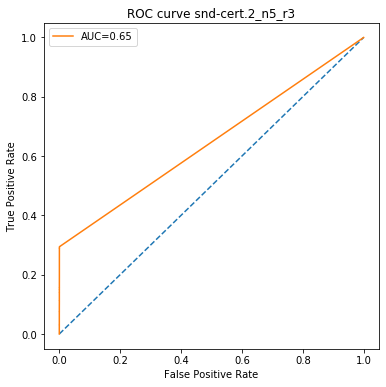

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.5.3.test
AUC: 0.6645181188958191


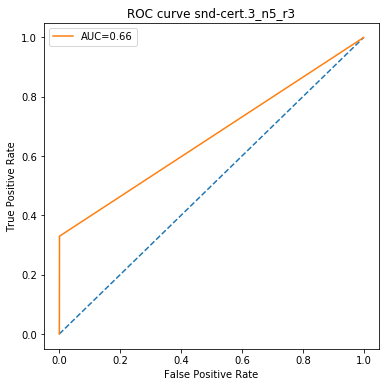

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.5.1.test
AUC: 0.6799093627603146


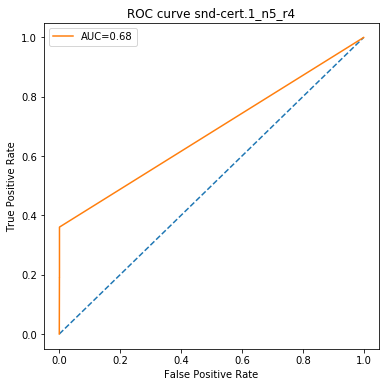

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.5.2.test
AUC: 0.6603927533477435


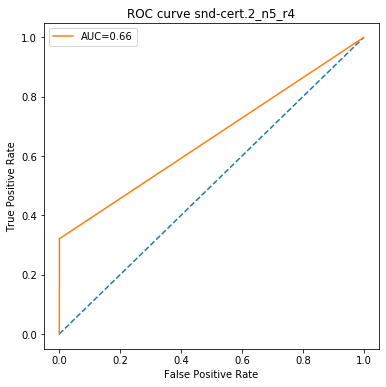

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.5.3.test
AUC: 0.6891979075109533


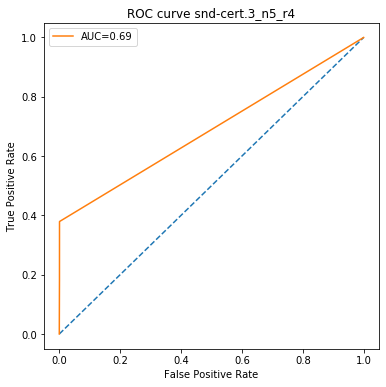

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.5.1.test
AUC: 0.6799492519176098


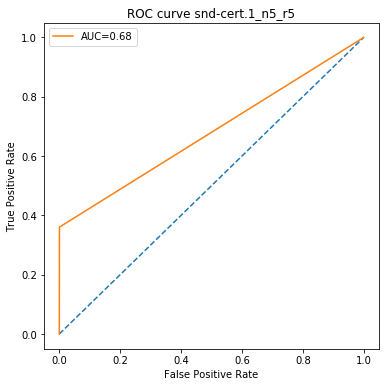

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.5.2.test
AUC: 0.660404886187665


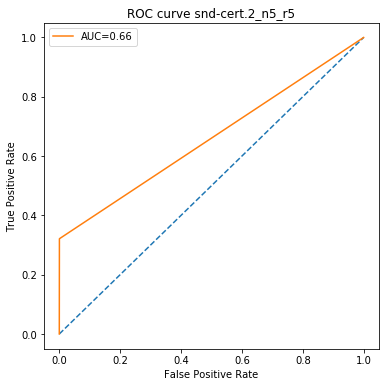

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.5.train -n 5 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.5.3.test
AUC: 0.6892447824709884


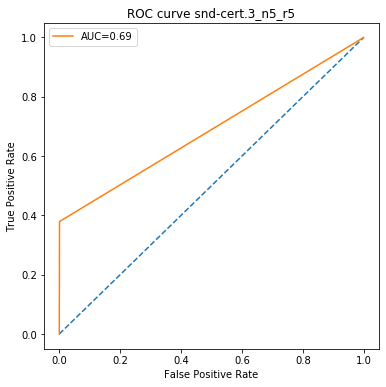

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.5325953259532595


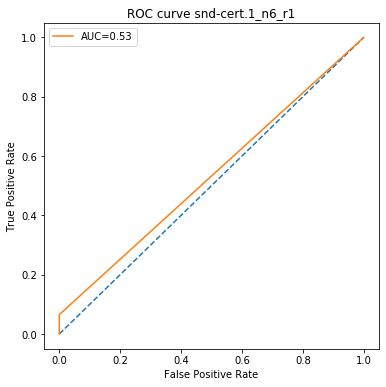

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.535454650559188


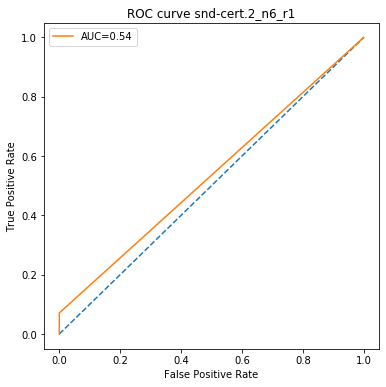

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.5361893430941919


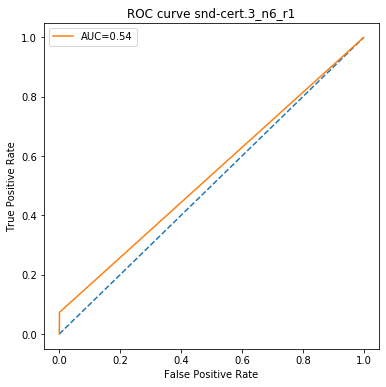

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.6340713407134071


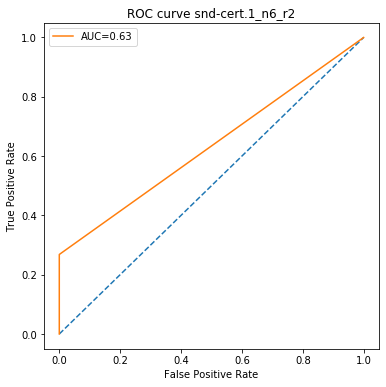

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.6167420851333913


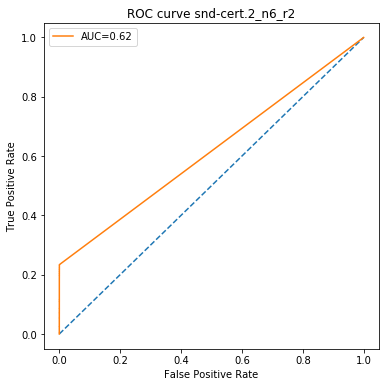

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.6391199229877845


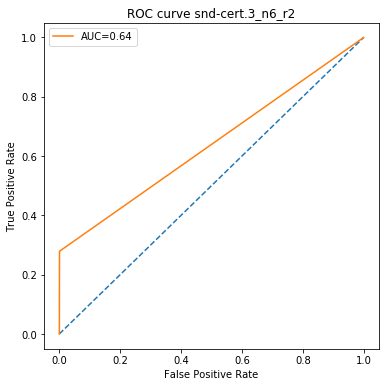

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.6623126824855771


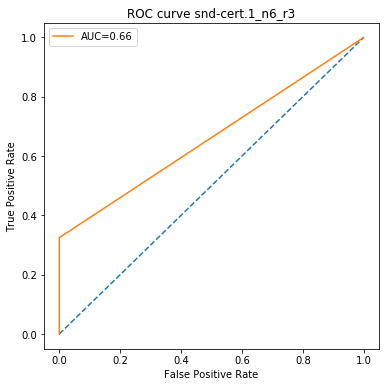

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.6448619210538524


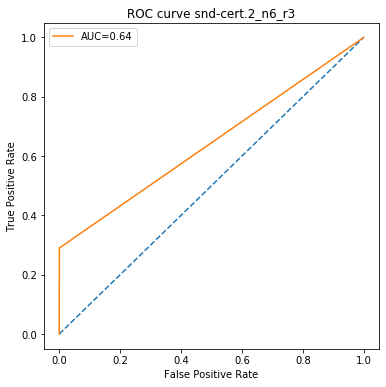

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.6625390671668691


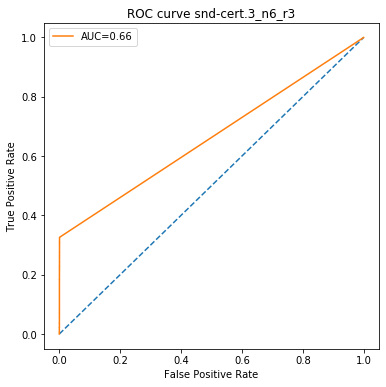

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.6684504864979325


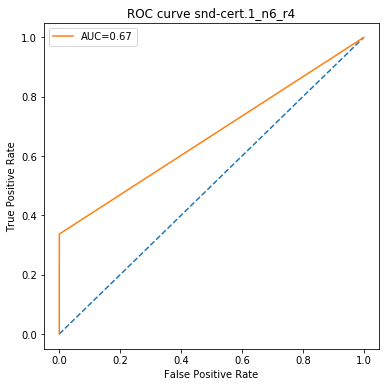

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.6528084234458694


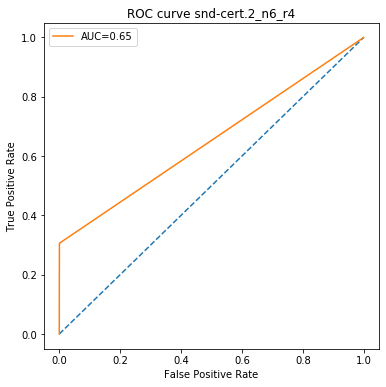

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.6736440093869038


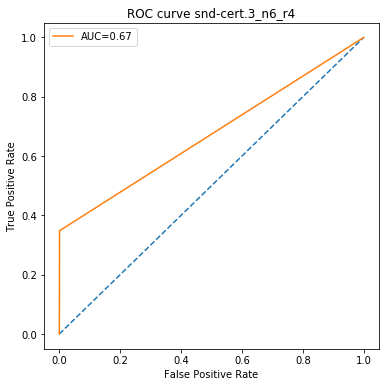

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.6690499487317231


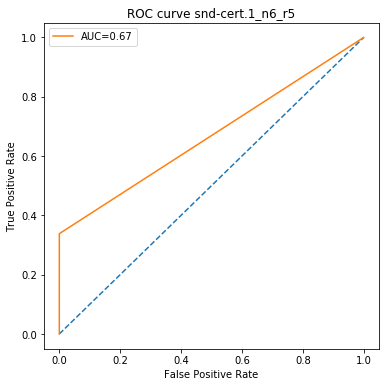

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.6540083890703956


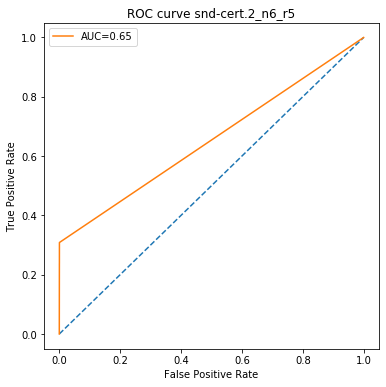

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.6742808614166473


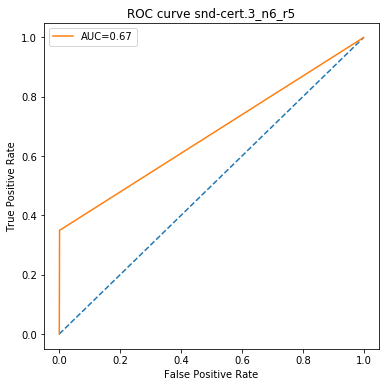

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.6702844909731593


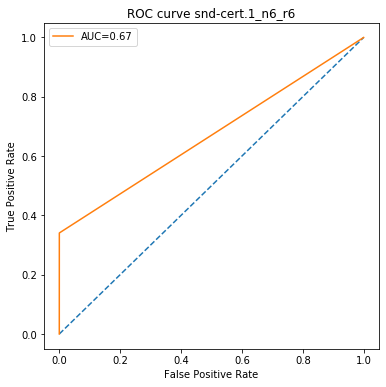

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.6558355465859983


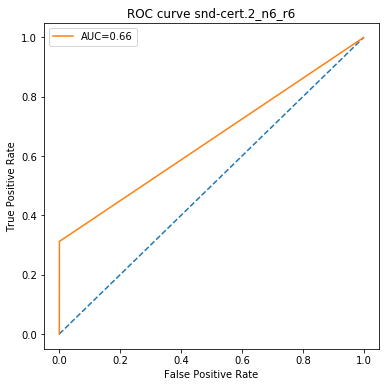

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.6779789481603415


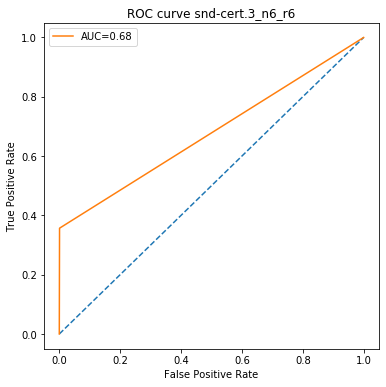

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.5467224546722455


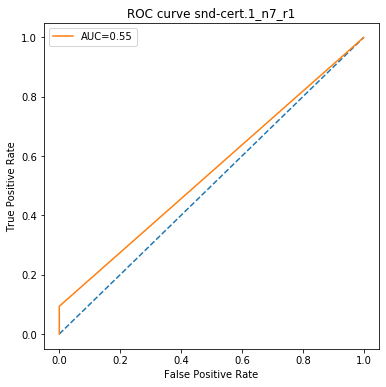

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.5456827585184758


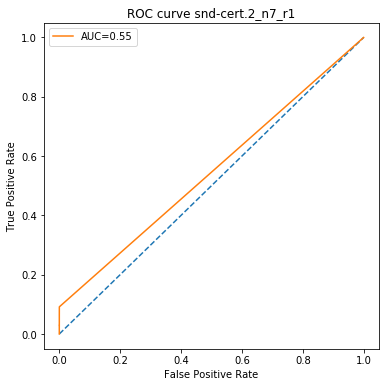

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.5544367854718176


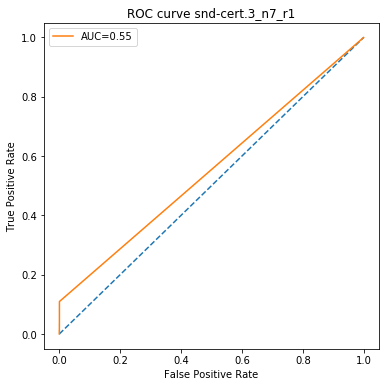

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.6588495252610065


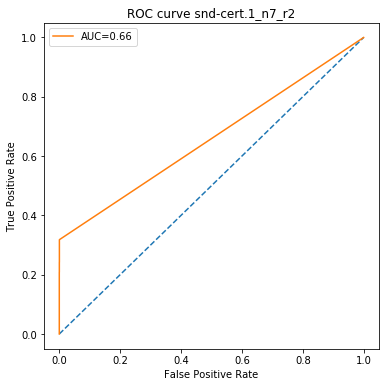

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.6460758001502389


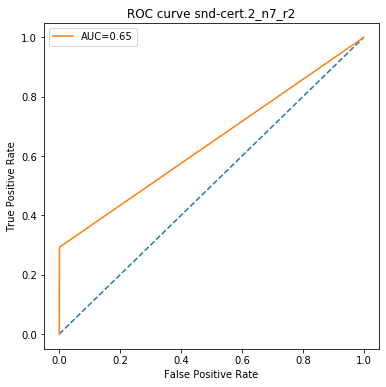

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.6671684055190511


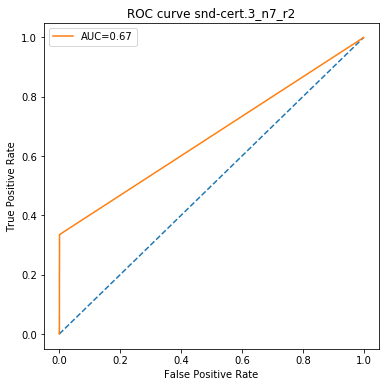

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.7129760031610067


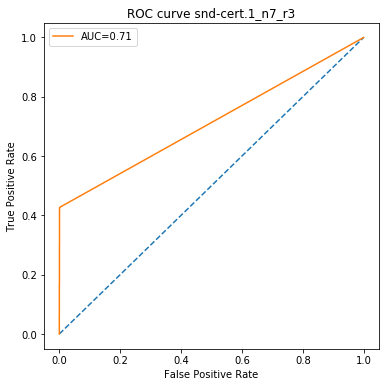

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.7007750239830495


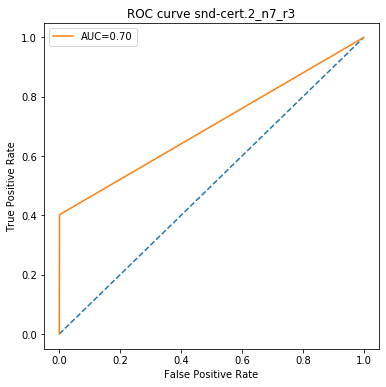

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.7252963761326124


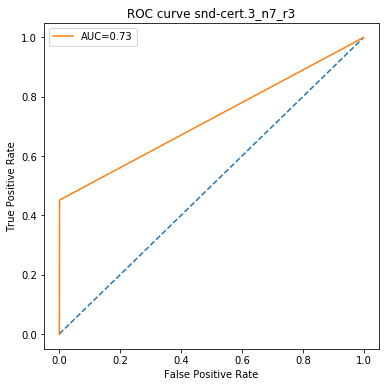

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.7164774531317251


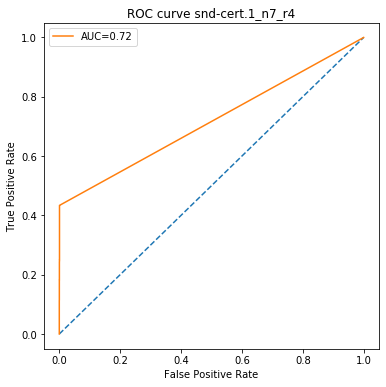

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.7070193942275165


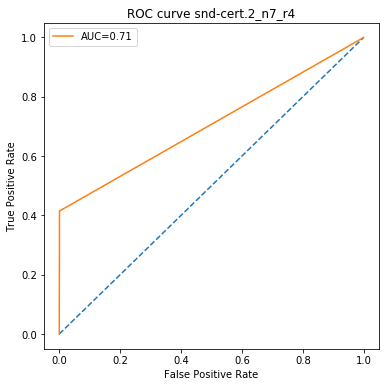

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.7302214873274789


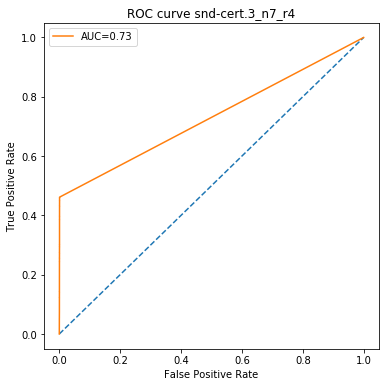

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.7171282347988269


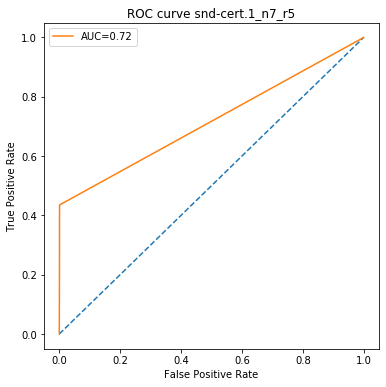

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.7077090798771274


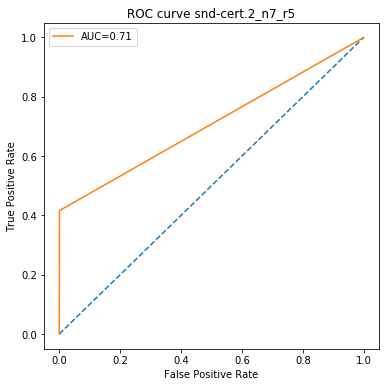

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.7302596244435666


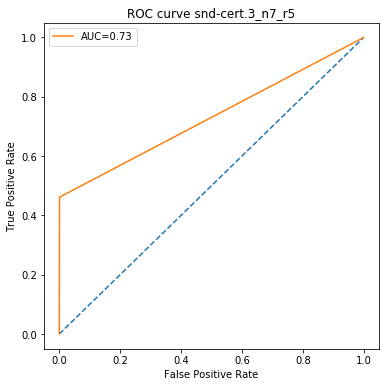

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.7506162081560559


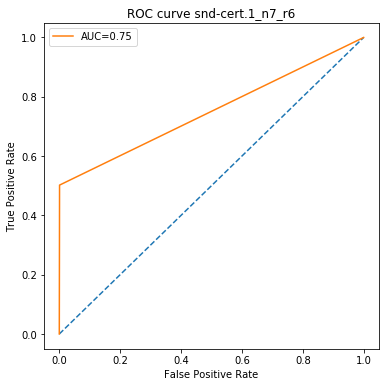

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.737494376881165


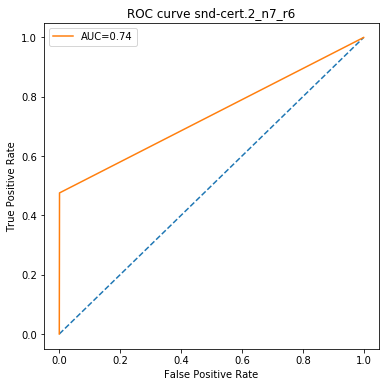

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.7610867023681583


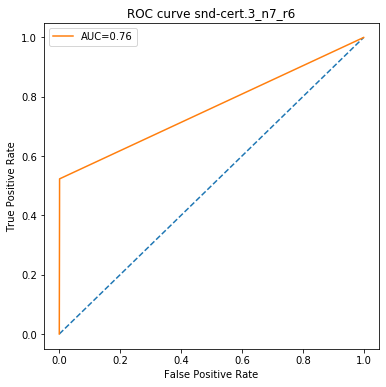

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.7520191400838702


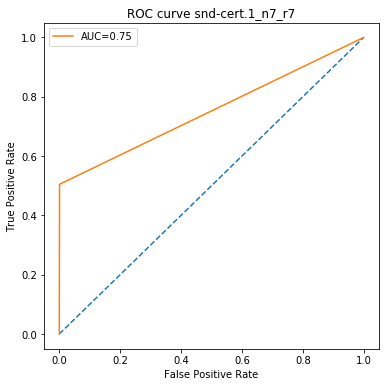

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.7388763802665475


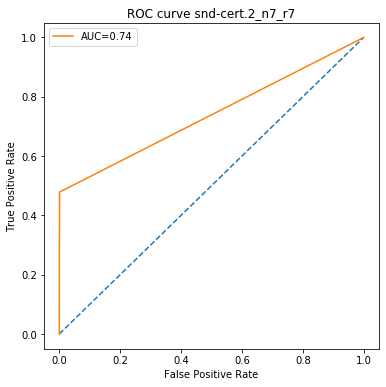

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.7617982817100463


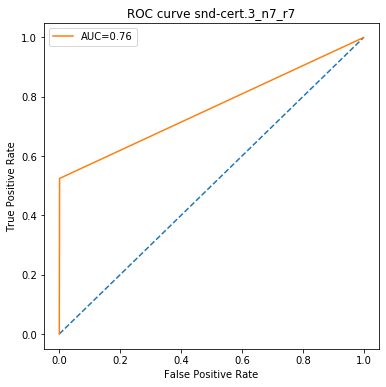

In [12]:
for n, r in chunk_r_tuples:
    self = f"-self {cert_data_path}snd-cert.{n}.train"
    params = f"-n {n} -r {r} -c -l"
    for i in range(1, TEST_N + 1):
        test = f"{cert_data_path}snd-cert.{n}.{i}.test"
        # run negative selection algorithm
        print(f"Execute command: !java {jar} {alpha} {self} {params} < {test}")
        output = !java {jar} {alpha} {self} {params} < {test}
        # string to float
        counts = [float(count) for count in output]
        # read labels and convert to float
        labels = read_data(cert_data_path + "snd-cert.{}.{}.labels".format(n, i))
        labels = [float(label) for label in labels]
        # perform AUC analysis - compute AUC and plot ROC
        fpr, tpr, thresholds = metrics.roc_curve(labels, counts, pos_label=1)
        auc = get_AUC(labels, counts)
        print("AUC:", auc)
        plot_ROC(fpr, tpr, "snd-cert.{}_n{}_r{}".format(i, n, r),
                 "ex2_snd-cert.{}_n{}_r{}".format(i, n, r))
        # store AUC in a dictionary
        auc_dict["snd-cert.{}_n{}_r{}".format(i, n, r)] = auc
    print("=================")

In [13]:
# save auc_dict
import pickle
with open('auc_dict.pkl', 'wb') as output:
    pickle.dump(auc_dict, output, pickle.HIGHEST_PROTOCOL)